In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_regression, RFE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
from datetime import datetime

# Configure output formatting
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
np.set_printoptions(precision=4, suppress=True)

class FeatureSelectionExperimentWithExternalTest:
    """Framework for running XGBoost feature selection experiments with an external test set"""
    
    def __init__(self, train_data_path, test_data_path, target_col='f', 
                 random_state=42, results_dir='results'):
        """
        Initialize the experiment framework
        
        Args:
            train_data_path: Path to the training CSV file
            test_data_path: Path to the test CSV file
            target_col: Name of the target column
            random_state: Random seed for reproducibility
            results_dir: Directory to save results
        """
        self.train_data_path = train_data_path
        self.test_data_path = test_data_path
        self.target_col = target_col
        self.random_state = random_state
        self.results_dir = results_dir
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # Results storage
        self.experiment_results = []
        self.feature_importances = {}
        
        # Create results directory if it doesn't exist
        import os
        os.makedirs(results_dir, exist_ok=True)
        
        print(f"Initialized feature selection experiment framework")
        print(f"Training data will be loaded from: {train_data_path}")
        print(f"Test data will be loaded from: {test_data_path}")
        print(f"Results will be saved to: {results_dir}")
    
    def load_data(self):
        """Load the training and test datasets"""
        print(f"Loading training data from: {self.train_data_path}")
        print(f"Loading test data from: {self.test_data_path}")
        
        try:
            # Load the full training dataset
            self.train_data = pd.read_csv(self.train_data_path)
            print(f"Training dataset loaded successfully with shape: {self.train_data.shape}")
            
            # Check if target column exists in training data
            if self.target_col not in self.train_data.columns:
                raise ValueError(f"Target column '{self.target_col}' not found in training dataset")
            
            # Load the test dataset
            self.test_data = pd.read_csv(self.test_data_path)
            print(f"Test dataset loaded successfully with shape: {self.test_data.shape}")
            
            # Check if target column exists in test data
            if self.target_col not in self.test_data.columns:
                raise ValueError(f"Target column '{self.target_col}' not found in test dataset")
            
            # Ensure training and test datasets have the same features
            if not set(self.train_data.columns) == set(self.test_data.columns):
                print("Warning: Training and test datasets have different columns!")
                # Identify common columns
                common_cols = list(set(self.train_data.columns) & set(self.test_data.columns))
                print(f"Using {len(common_cols)} common columns including target column.")
                self.train_data = self.train_data[common_cols]
                self.test_data = self.test_data[common_cols]
            
            # Separate features from target in training data
            self.X_train = self.train_data.drop([self.target_col], axis=1)
            self.y_train = self.train_data[self.target_col]
            
            # Separate features from target in test data
            self.X_test = self.test_data.drop([self.target_col], axis=1)
            self.y_test = self.test_data[self.target_col]
            
            print(f"Features: {self.X_train.shape[1]} columns")
            print(f"Training set: {self.X_train.shape[0]} samples")
            print(f"Testing set: {self.X_test.shape[0]} samples")
            
            return True
        
        except Exception as e:
            print(f"Error loading data: {e}")
            return False
    
    def calculate_metrics(self, y_true, y_pred):
        """Calculate performance metrics"""
        mse = np.mean((y_true - y_pred) ** 2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(y_true - y_pred))
        pearson_corr, p_value = pearsonr(y_true, y_pred)
        
        return {
            'mse': float(mse),
            'rmse': float(rmse),
            'mae': float(mae),
            'pearson': float(pearson_corr),
            'p_value': float(p_value)
        }
    
    def run_baseline_model(self, params=None):
        """Run baseline XGBoost model using all features"""
        print("\n=== Running Baseline Model (All Features) ===")
        
        if params is None:
            params = {
                'objective': 'reg:squarederror',
                'learning_rate': 0.1,
                'max_depth': 6,
                'n_estimators': 100,
                'random_state': self.random_state
            }
        
        # Train the model
        start_time = time.time()
        model = xgb.XGBRegressor(**params)
        model.fit(self.X_train, self.y_train)
        training_time = time.time() - start_time
        
        # Make predictions
        y_train_pred = model.predict(self.X_train)
        y_test_pred = model.predict(self.X_test)
        
        # Calculate metrics
        train_metrics = self.calculate_metrics(self.y_train, y_train_pred)
        test_metrics = self.calculate_metrics(self.y_test, y_test_pred)
        
        # Save feature importance
        feature_importance = model.feature_importances_
        importance_df = pd.DataFrame({
            'Feature': self.X_train.columns,
            'Importance': feature_importance
        }).sort_values('Importance', ascending=False)
        
        self.feature_importances['baseline'] = importance_df
        
        # Record results
        result = {
            'experiment_id': 'baseline',
            'description': 'All features',
            'num_features': self.X_train.shape[1],
            'params': params,
            'training_time': training_time,
            'train_metrics': train_metrics,
            'test_metrics': test_metrics
        }
        
        self.experiment_results.append(result)
        
        # Print results
        print(f"Baseline model trained on {self.X_train.shape[1]} features")
        print(f"Training Time: {training_time:.2f} seconds")
        print(f"Train MSE: {train_metrics['mse']:.8f}")
        print(f"Test MSE: {test_metrics['mse']:.8f}")
        print(f"Train Pearson: {train_metrics['pearson']:.8f}")
        print(f"Test Pearson: {test_metrics['pearson']:.8f}")
        
        # Show top features
        print("\nTop 10 features by importance:")
        print(importance_df.head(10).to_string(index=False))
        
        return model, importance_df
    
    def run_importance_threshold_experiment(self, thresholds=[0.001, 0.005, 0.01], params=None):
        """Run experiments using features above importance thresholds"""
        print("\n=== Running Feature Selection by Importance Thresholds ===")
        
        if params is None:
            params = {
                'objective': 'reg:squarederror',
                'learning_rate': 0.1,
                'max_depth': 6,
                'n_estimators': 100,
                'random_state': self.random_state
            }
        
        # Make sure we have feature importance data
        if 'baseline' not in self.feature_importances:
            print("Running baseline model first to get feature importances...")
            self.run_baseline_model(params)
        
        importance_df = self.feature_importances['baseline']
        
        # Run experiments for each threshold
        for threshold in thresholds:
            print(f"\nTesting importance threshold: {threshold}")
            
            # Select features above threshold
            selected_features = importance_df[importance_df['Importance'] > threshold]['Feature'].tolist()
            num_selected = len(selected_features)
            
            print(f"Selected {num_selected} features ({num_selected/self.X_train.shape[1]:.1%} of total)")
            
            if num_selected == 0:
                print("No features selected with this threshold, skipping...")
                continue
            
            # Create feature subset
            X_train_selected = self.X_train[selected_features]
            X_test_selected = self.X_test[selected_features]
            
            # Train model with selected features
            start_time = time.time()
            model = xgb.XGBRegressor(**params)
            model.fit(X_train_selected, self.y_train)
            training_time = time.time() - start_time
            
            # Make predictions
            y_train_pred = model.predict(X_train_selected)
            y_test_pred = model.predict(X_test_selected)
            
            # Calculate metrics
            train_metrics = self.calculate_metrics(self.y_train, y_train_pred)
            test_metrics = self.calculate_metrics(self.y_test, y_test_pred)
            
            # Record results
            result = {
                'experiment_id': f'importance_threshold_{threshold}',
                'description': f'Features with importance > {threshold}',
                'num_features': num_selected,
                'params': params,
                'training_time': training_time,
                'train_metrics': train_metrics,
                'test_metrics': test_metrics,
                'selected_features': selected_features
            }
            
            self.experiment_results.append(result)
            
            # Print results
            print(f"Training Time: {training_time:.2f} seconds")
            print(f"Train MSE: {train_metrics['mse']:.8f}")
            print(f"Test MSE: {test_metrics['mse']:.8f}")
            print(f"Train Pearson: {train_metrics['pearson']:.8f}")
            print(f"Test Pearson: {test_metrics['pearson']:.8f}")
    
    def run_top_k_experiment(self, k_values=[10, 20, 50, 100], params=None):
        """Run experiments selecting top K features by importance"""
        print("\n=== Running Feature Selection by Top K Features ===")
        
        if params is None:
            params = {
                'objective': 'reg:squarederror',
                'learning_rate': 0.1,
                'max_depth': 6,
                'n_estimators': 100,
                'random_state': self.random_state
            }
        
        # Make sure we have feature importance data
        if 'baseline' not in self.feature_importances:
            print("Running baseline model first to get feature importances...")
            self.run_baseline_model(params)
        
        importance_df = self.feature_importances['baseline']
        
        # Run experiments for each K value
        for k in k_values:
            print(f"\nSelecting top {k} features")
            
            # Select top K features
            if k > len(importance_df):
                print(f"K value {k} exceeds number of features, using all features")
                k = len(importance_df)
            
            selected_features = importance_df.head(k)['Feature'].tolist()
            
            # Create feature subset
            X_train_selected = self.X_train[selected_features]
            X_test_selected = self.X_test[selected_features]
            
            # Train model with selected features
            start_time = time.time()
            model = xgb.XGBRegressor(**params)
            model.fit(X_train_selected, self.y_train)
            training_time = time.time() - start_time
            
            # Make predictions
            y_train_pred = model.predict(X_train_selected)
            y_test_pred = model.predict(X_test_selected)
            
            # Calculate metrics
            train_metrics = self.calculate_metrics(self.y_train, y_train_pred)
            test_metrics = self.calculate_metrics(self.y_test, y_test_pred)
            
            # Record results
            result = {
                'experiment_id': f'top_k_{k}',
                'description': f'Top {k} features by importance',
                'num_features': k,
                'params': params,
                'training_time': training_time,
                'train_metrics': train_metrics,
                'test_metrics': test_metrics,
                'selected_features': selected_features
            }
            
            self.experiment_results.append(result)
            
            # Print results
            print(f"Training Time: {training_time:.2f} seconds")
            print(f"Train MSE: {train_metrics['mse']:.8f}")
            print(f"Test MSE: {test_metrics['mse']:.8f}")
            print(f"Train Pearson: {train_metrics['pearson']:.8f}")
            print(f"Test Pearson: {test_metrics['pearson']:.8f}")
    
    def run_correlation_experiment(self, k_values=[10, 20, 50, 100]):
        """Run experiments selecting features by correlation with target"""
        print("\n=== Running Feature Selection by Correlation ===")
        
        # Calculate correlation with the target
        correlation_df = pd.DataFrame()
        correlation_df['Feature'] = self.X_train.columns
        correlation_df['Correlation'] = [
            abs(pearsonr(self.X_train[feature], self.y_train)[0]) 
            for feature in self.X_train.columns
        ]
        correlation_df = correlation_df.sort_values('Correlation', ascending=False)
        
        self.feature_importances['correlation'] = correlation_df
        
        # Run experiments for each K value
        for k in k_values:
            print(f"\nSelecting top {k} features by correlation")
            
            # Select top K features
            if k > len(correlation_df):
                print(f"K value {k} exceeds number of features, using all features")
                k = len(correlation_df)
            
            selected_features = correlation_df.head(k)['Feature'].tolist()
            
            # Create feature subset
            X_train_selected = self.X_train[selected_features]
            X_test_selected = self.X_test[selected_features]
            
            # Train model with selected features
            start_time = time.time()
            model = xgb.XGBRegressor(
                objective='reg:squarederror',
                learning_rate=0.1,
                max_depth=6,
                n_estimators=100,
                random_state=self.random_state
            )
            model.fit(X_train_selected, self.y_train)
            training_time = time.time() - start_time
            
            # Make predictions
            y_train_pred = model.predict(X_train_selected)
            y_test_pred = model.predict(X_test_selected)
            
            # Calculate metrics
            train_metrics = self.calculate_metrics(self.y_train, y_train_pred)
            test_metrics = self.calculate_metrics(self.y_test, y_test_pred)
            
            # Record results
            result = {
                'experiment_id': f'correlation_top_{k}',
                'description': f'Top {k} features by correlation',
                'num_features': k,
                'params': {
                    'objective': 'reg:squarederror',
                    'learning_rate': 0.1,
                    'max_depth': 6,
                    'n_estimators': 100,
                },
                'training_time': training_time,
                'train_metrics': train_metrics,
                'test_metrics': test_metrics,
                'selected_features': selected_features
            }
            
            self.experiment_results.append(result)
            
            # Print results
            print(f"Training Time: {training_time:.2f} seconds")
            print(f"Train MSE: {train_metrics['mse']:.8f}")
            print(f"Test MSE: {test_metrics['mse']:.8f}")
            print(f"Train Pearson: {train_metrics['pearson']:.8f}")
            print(f"Test Pearson: {test_metrics['pearson']:.8f}")
    
    def run_recursive_feature_elimination(self, n_features_to_select=[10, 20, 50, 100]):
        """Run experiments using Recursive Feature Elimination"""
        print("\n=== Running Recursive Feature Elimination ===")
        
        for n in n_features_to_select:
            print(f"\nSelecting {n} features using RFE")
            
            # Create estimator for RFE
            estimator = xgb.XGBRegressor(
                objective='reg:squarederror',
                learning_rate=0.1,
                max_depth=6,
                n_estimators=100,
                random_state=self.random_state
            )
            
            # Use RFE to select features
            selector = RFE(estimator, n_features_to_select=n, step=0.05, verbose=0)
            
            # Apply RFE on the training set
            start_time = time.time()
            selector.fit(self.X_train, self.y_train)
            selection_time = time.time() - start_time
            
            # Get the selected features
            selected_features = self.X_train.columns[selector.support_].tolist()
            
            # Create feature subset
            X_train_selected = self.X_train[selected_features]
            X_test_selected = self.X_test[selected_features]
            
            # Train model with selected features
            model_start_time = time.time()
            model = xgb.XGBRegressor(
                objective='reg:squarederror',
                learning_rate=0.1,
                max_depth=6,
                n_estimators=100,
                random_state=self.random_state
            )
            model.fit(X_train_selected, self.y_train)
            training_time = time.time() - model_start_time
            
            # Make predictions
            y_train_pred = model.predict(X_train_selected)
            y_test_pred = model.predict(X_test_selected)
            
            # Calculate metrics
            train_metrics = self.calculate_metrics(self.y_train, y_train_pred)
            test_metrics = self.calculate_metrics(self.y_test, y_test_pred)
            
            # Record results
            result = {
                'experiment_id': f'rfe_{n}',
                'description': f'RFE with {n} features',
                'num_features': n,
                'params': {
                    'objective': 'reg:squarederror',
                    'learning_rate': 0.1,
                    'max_depth': 6,
                    'n_estimators': 100,
                },
                'selection_time': selection_time,
                'training_time': training_time,
                'train_metrics': train_metrics,
                'test_metrics': test_metrics,
                'selected_features': selected_features
            }
            
            self.experiment_results.append(result)
            
            # Print results
            print(f"Feature Selection Time: {selection_time:.2f} seconds")
            print(f"Training Time: {training_time:.2f} seconds")
            print(f"Train MSE: {train_metrics['mse']:.8f}")
            print(f"Test MSE: {test_metrics['mse']:.8f}")
            print(f"Train Pearson: {train_metrics['pearson']:.8f}")
            print(f"Test Pearson: {test_metrics['pearson']:.8f}")
    
    def generate_results_table(self):
        """Generate a summary table of all experimental results"""
        print("\n=== Generating Results Summary ===")
        
        if not self.experiment_results:
            print("No experiment results to summarize")
            return None
        
        # Create a DataFrame with the results
        results_df = pd.DataFrame()
        
        for result in self.experiment_results:
            row = {
                'Experiment': result['experiment_id'],
                'Description': result['description'],
                'Features': result['num_features'],
                'Training Time (s)': result['training_time'],
                'Train MSE': result['train_metrics']['mse'],
                'Test MSE': result['test_metrics']['mse'],
                'Train RMSE': result['train_metrics']['rmse'],
                'Test RMSE': result['test_metrics']['rmse'],
                'Train MAE': result['train_metrics']['mae'],
                'Test MAE': result['test_metrics']['mae'],
                'Train Pearson': result['train_metrics']['pearson'],
                'Test Pearson': result['test_metrics']['pearson']
            }
            
            results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)
        
        # Sort by test MSE (or another metric of choice)
        results_df = results_df.sort_values('Test MSE')
        
        # Save results to CSV
        results_path = f"{self.results_dir}/experiment_results_{self.timestamp}.csv"
        results_df.to_csv(results_path, index=False)
        print(f"Results saved to {results_path}")
        
        # Calculate the improvement over baseline
        if 'baseline' in results_df['Experiment'].values:
            baseline_mse = results_df[results_df['Experiment'] == 'baseline']['Test MSE'].values[0]
            results_df['MSE Improvement (%)'] = 100 * (baseline_mse - results_df['Test MSE']) / baseline_mse
        
        return results_df
    
    def plot_results(self, results_df=None):
        """Generate plots comparing the experimental results"""
        if results_df is None:
            results_df = self.generate_results_table()
            
        if results_df is None or len(results_df) == 0:
            print("No results to plot")
            return
        
        # 1. Plot MSE vs Number of Features
        plt.figure(figsize=(12, 6))
        sns.scatterplot(data=results_df, x='Features', y='Test MSE')
        plt.title('Test MSE vs Number of Features')
        plt.xscale('log')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f"{self.results_dir}/mse_vs_features_{self.timestamp}.png")
        
        # 2. Plot Test Pearson Correlation vs Number of Features
        plt.figure(figsize=(12, 6))
        sns.scatterplot(data=results_df, x='Features', y='Test Pearson')
        plt.title('Test Pearson Correlation vs Number of Features')
        plt.xscale('log')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f"{self.results_dir}/pearson_vs_features_{self.timestamp}.png")
        
        # 3. Plot Training Time vs Number of Features
        plt.figure(figsize=(12, 6))
        sns.scatterplot(data=results_df, x='Features', y='Training Time (s)')
        plt.title('Training Time vs Number of Features')
        plt.xscale('log')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f"{self.results_dir}/time_vs_features_{self.timestamp}.png")
        
        # 4. Bar plot comparing Test MSE across experiments
        plt.figure(figsize=(14, 8))
        results_plot_df = results_df.sort_values('Test MSE')[:10]  # Top 10 experiments
        sns.barplot(data=results_plot_df, x='Experiment', y='Test MSE')
        plt.title('Top 10 Experiments by Test MSE')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(f"{self.results_dir}/top_experiments_{self.timestamp}.png")
        
        print(f"Plots saved to {self.results_dir} directory")
    
    def save_experiment_details(self):
        """Save all experiment details including feature lists"""
        if not self.experiment_results:
            print("No experiment results to save")
            return
        
        # Create a clean version for JSON serialization
        serializable_results = []
        
        for result in self.experiment_results:
            # Make a copy to avoid modifying the original
            clean_result = result.copy()
            
            # Convert any numpy types to native Python types
            for key in clean_result:
                if isinstance(clean_result[key], dict):
                    for subkey in clean_result[key]:
                        if isinstance(clean_result[key][subkey], (np.float32, np.float64, np.int32, np.int64)):
                            clean_result[key][subkey] = float(clean_result[key][subkey])
            
            serializable_results.append(clean_result)
        
        # Save to JSON file
        details_path = f"{self.results_dir}/experiment_details_{self.timestamp}.json"
        with open(details_path, 'w') as f:
            json.dump(serializable_results, f, indent=2)
        
        print(f"Detailed experiment results saved to {details_path}")
    
    def run_all_experiments(self):
        """Run all feature selection experiments"""
        # Make sure data is loaded
        if not hasattr(self, 'X_train') or self.X_train is None:
            if not self.load_data():
                print("Failed to load data, exiting")
                return
        
        # Run baseline model
        self.run_baseline_model()
        
        # Run importance threshold experiments
        self.run_importance_threshold_experiment(thresholds=[0.001, 0.002, 0.005, 0.01])
        
        # Run top K features experiments
        self.run_top_k_experiment(k_values=[10, 20, 50, 100, 200])
        
        # Run correlation-based feature selection
        self.run_correlation_experiment(k_values=[10, 20, 50, 100, 200])
        
        # Run RFE (skip if dataset is large as this can be slow)
        if self.X_train.shape[0] < 10000 and self.X_train.shape[1] < 500:
            self.run_recursive_feature_elimination(n_features_to_select=[10, 20, 50, 100])
        
        # Generate and plot results
        results_df = self.generate_results_table()
        self.plot_results(results_df)
        self.save_experiment_details()
        
        print("\n=== Experiment Run Complete ===")
        if results_df is not None:
            print("\nTop 5 experiments by Test MSE:")
            top_results = results_df.sort_values('Test MSE').head(5)
            print(top_results[['Experiment', 'Description', 'Features', 'Test MSE', 'Test Pearson']].to_string(index=False))
        
        return results_df

Initialized feature selection experiment framework
Training data will be loaded from: gold_data_train.csv
Test data will be loaded from: gold_data_test.csv
Results will be saved to: feature_selection_results_external_test
Loading training data from: gold_data_train.csv
Loading test data from: gold_data_test.csv
Training dataset loaded successfully with shape: (68492, 357)
Test dataset loaded successfully with shape: (9472, 233)
Using 149 common columns including target column.
Features: 148 columns
Training set: 68492 samples
Testing set: 9472 samples

=== Running Baseline Model (All Features) ===
Baseline model trained on 148 features
Training Time: 1.08 seconds
Train MSE: 0.00272175
Test MSE: 0.00644092
Train Pearson: 0.76079409
Test Pearson: 0.27655303

Top 10 features by importance:
                  Feature  Importance
      Glycan_AcetylGroups    0.055863
          Protein_S_count    0.054031
          Protein_M_count    0.044954
        Protein_I_percent    0.027700
          Pr

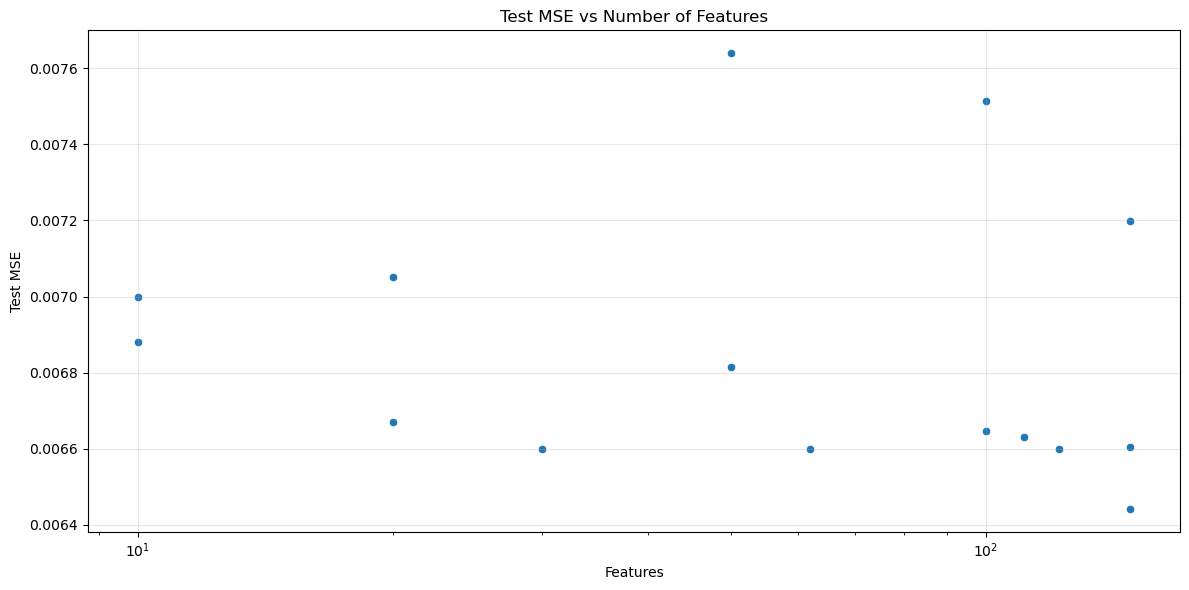

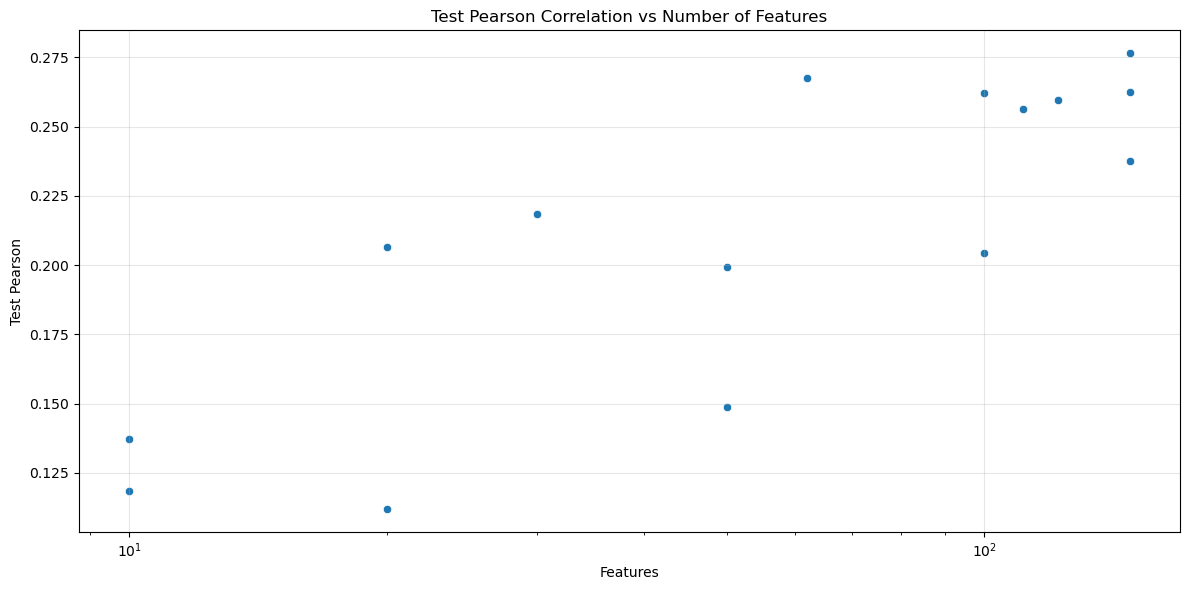

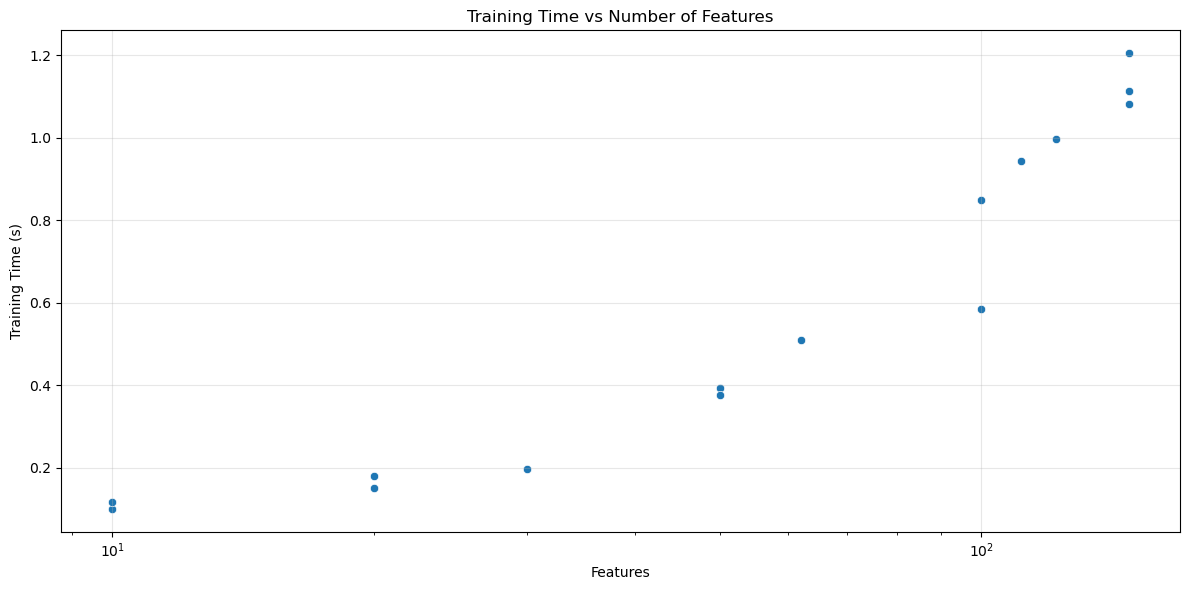

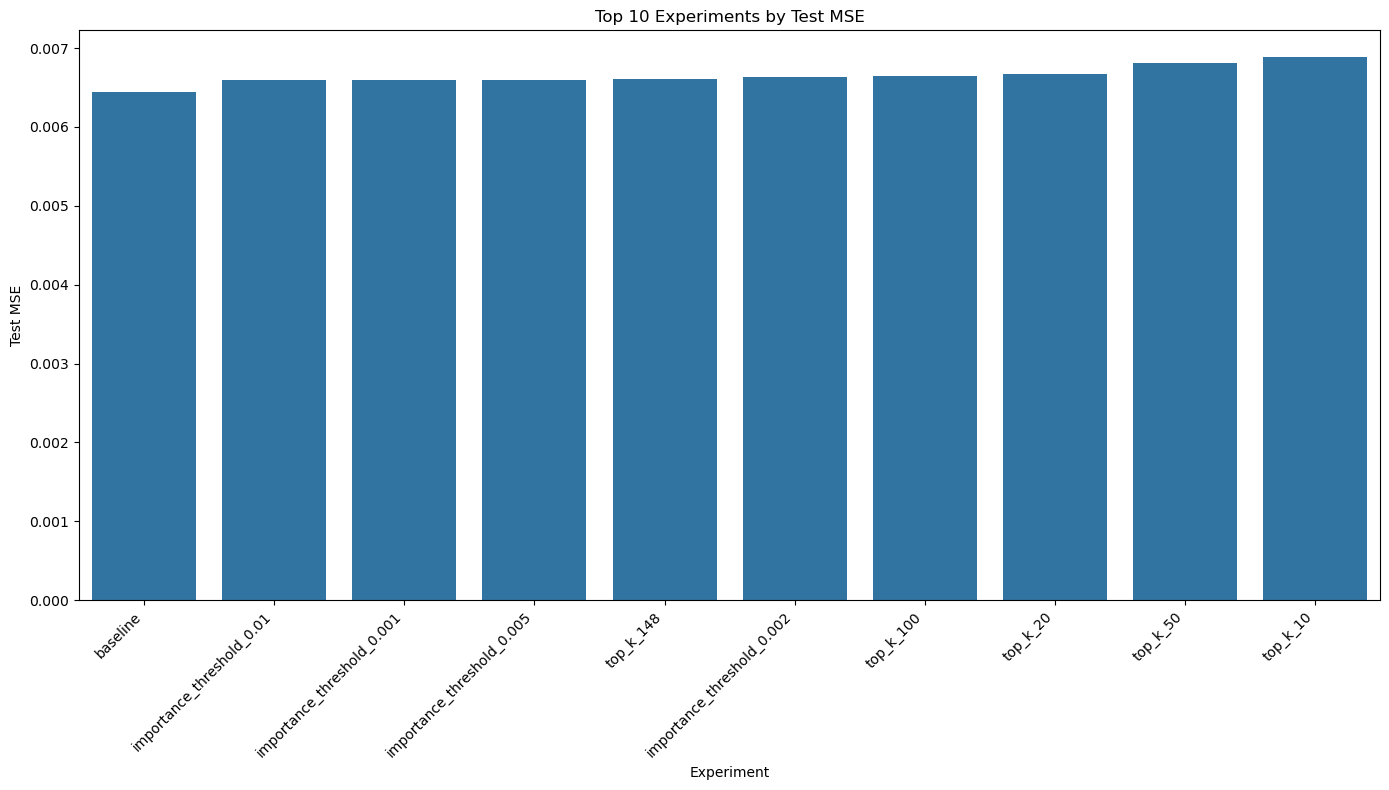

In [7]:
# Create experiment with separate training and test files
experiment = FeatureSelectionExperimentWithExternalTest(
    train_data_path='gold_data_train.csv',  # Your existing training data
    test_data_path='gold_data_test.csv',  # The external test data
    target_col='f',  # Target column name
    results_dir='feature_selection_results_external_test'  # Store results in a different directory
)

# Run all experiments
results = experiment.run_all_experiments()

# Display the top 5 models with their key metrics
print("\nTop 5 models by test MSE:")
#top_models = results.sort_values('Test MSE').head(5)
#print(top_models[['Experiment', 'Description', 'Features', 'Test MSE', 'Test Pearson']].to_string(index=False))

print("\nImportance of feature selection:")
baseline_mse = results[results['Experiment'] == 'baseline']['Test MSE'].values[0]
best_mse = results['Test MSE'].min()
improvement = 100 * (baseline_mse - best_mse) / baseline_mse
print(f"Best model improves over baseline by {improvement:.2f}% in terms of MSE")

print("\nDone! Results and visualizations saved to 'feature_selection_results_external_test' directory")

In [8]:
results

,Experiment,Description,Features,Training Time (s),Train MSE,Test MSE,Train RMSE,Test RMSE,Train MAE,Test MAE,Train Pearson,Test Pearson,MSE Improvement (%)
0,baseline,All features,148,1.083253,0.002722,0.006441,0.052170,0.080255,0.018542,0.027331,0.760794,0.276553,0.000000
4,importance_threshold_0.01,Features with importance > 0.01,30,0.196445,0.004224,0.006598,0.064992,0.081230,0.022592,0.029610,0.564104,0.218590,-2.442760
1,importance_threshold_0.001,Features with importance > 0.001,122,0.998426,0.002732,0.006599,0.052271,0.081237,0.018517,0.028046,0.759580,0.259665,-2.461073
3,importance_threshold_0.005,Features with importance > 0.005,62,0.509912,0.002703,0.006600,0.051986,0.081241,0.018483,0.028446,0.760867,0.267602,-2.472168
9,top_k_148,Top 148 features by importance,148,1.114306,0.002722,0.006605,0.052170,0.081269,0.018542,0.028523,0.760794,0.262463,-2.541539
2,importance_threshold_0.002,Features with importance > 0.002,111,0.944692,0.002697,0.006631,0.051936,0.081430,0.018493,0.028779,0.763793,0.256405,-2.948002
8,top_k_100,Top 100 features by importance,100,0.850213,0.002706,0.006646,0.052018,0.081523,0.018606,0.028604,0.762180,0.262252,-3.183635
6,top_k_20,Top 20 features by importance,20,0.151399,0.004355,0.006670,0.065989,0.081669,0.022980,0.029685,0.545612,0.206408,-3.554498
7,top_k_50,Top 50 features by importance,50,0.392608,0.004033,0.006815,0.063509,0.082550,0.022039,0.031159,0.593616,0.199387,-5.800148
5,top_k_10,Top 10 features by importance,10,0.098540,0.004551,0.006881,0.067460,0.082954,0.023711,0.026844,0.511101,0.137374,-6.839351
